In [47]:
import pandas as pd
from google.cloud import bigquery
from google.oauth2 import service_account
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from os import getenv
from dotenv import load_dotenv

load_dotenv()

True

In [48]:
PROJECT_ID= getenv("PROJECT_ID")
CRED_FILE_PATH= getenv("CRED_FILE_PATH")
credentials = service_account.Credentials.from_service_account_file(CRED_FILE_PATH)
client = bigquery.Client(project = PROJECT_ID, credentials = credentials)
print("client connected", client)

client connected <google.cloud.bigquery.client.Client object at 0x174882c60>


In [37]:
# Training data (seasons up to 2016)
train_query = """
SELECT
    game_id,
    season,
    scheduled_date,
    team_id,
    home_team,
    win,
    points,
    field_goals_pct,
    three_points_pct,
    free_throws_pct,
    rebounds,
    assists,
    turnovers,
    steals,
    blocks,
    personal_fouls,
    fast_break_pts,
    second_chance_pts,
    points_off_turnovers
FROM `bigquery-public-data.ncaa_basketball.mbb_teams_games_sr`
WHERE season <= 2016
  AND win IS NOT NULL
"""

# Test data (2017-18 season, using season=2017)
test_query = """
SELECT
    game_id,
    season,
    scheduled_date,
    team_id,
    home_team,
    win,
    points,
    field_goals_pct,
    three_points_pct,
    free_throws_pct,
    rebounds,
    assists,
    turnovers,
    steals,
    blocks,
    personal_fouls,
    fast_break_pts,
    second_chance_pts,
    points_off_turnovers
FROM `bigquery-public-data.ncaa_basketball.mbb_teams_games_sr`
WHERE season = 2017  # Key change: Using 2017 instead of 2018
  AND win IS NOT NULL
"""


In [38]:
# Load data
df_train = client.query(train_query).to_dataframe()
df_test = client.query(test_query).to_dataframe()

print(f"Train samples: {len(df_train)}")
print(f"Test samples: {len(df_test)}")

/opt/homebrew/anaconda3/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Train samples: 47600
Test samples: 12008


In [39]:
# Data cleaning
def clean_data(df):
    # Convert booleans to int
    for col in ['home_team', 'win']:
        df[col] = df[col].astype(int)
    
    # Fill numeric NaNs (exclude dates)
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    df[num_cols] = df[num_cols].fillna(0)
    
    # Drop date column if exists
    return df.drop(columns=['scheduled_date'], errors='ignore')

df_train = clean_data(df_train)
df_test = clean_data(df_test)

# Feature selection
features = [
    'home_team', 'points', 'field_goals_pct', 'three_points_pct',
    'free_throws_pct', 'rebounds', 'assists', 'turnovers',
    'steals', 'blocks', 'personal_fouls',
    'fast_break_pts', 'second_chance_pts', 'points_off_turnovers'
]

# Verify all features exist
features = [f for f in features if f in df_train.columns]
print("Features used:", features)

# Prepare data
X_train = df_train[features]
y_train = df_train['win']
X_test = df_test[features]
y_test = df_test['win']
print(f"Train samples X : {X_train}")
print(f"Train samples y : {y_train}")
print(f"Test samples: {len(df_test)}")

Features used: ['home_team', 'points', 'field_goals_pct', 'three_points_pct', 'free_throws_pct', 'rebounds', 'assists', 'turnovers', 'steals', 'blocks', 'personal_fouls', 'fast_break_pts', 'second_chance_pts', 'points_off_turnovers']
Train samples X :        home_team  points  field_goals_pct  three_points_pct  free_throws_pct  \
0              1      71             36.9              13.3             55.9   
1              1      88             57.4              54.5             75.0   
2              1     128             57.9              50.0             88.6   
3              0      56             45.1              33.3             44.4   
4              0      30             22.6               7.1             55.6   
...          ...     ...              ...               ...              ...   
47595          0      77             43.6              57.1             67.6   
47596          0      58             35.4              33.3             69.0   
47597          1      68    

In [40]:
# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [41]:
# Predict
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

In [42]:
# Evaluate
print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"Recall: {recall_score(y_test, y_pred):.3f}")


Accuracy: 0.842
Precision: 0.814
Recall: 0.887


In [43]:
# Display predictions
results = df_test[['game_id', 'team_id']].copy()
results['predicted_win'] = y_pred
results['win_probability'] = y_prob
print("\nTop 10 predictions:")
print(results.head(10))


Top 10 predictions:
                                game_id                               team_id  \
0  1a689aee-fec2-49df-822d-993e2826744b  db6e1cab-3fa3-4a93-a673-8b2a358ff4bf   
1  dfc8f2a4-ce1c-4023-b53a-e26d8bbd9bc9  f38b58de-3273-4723-a78b-2f918e9aa2d5   
2  e3192dc1-5e06-439f-a91c-fab05893591e  8cd24de1-2be8-4b77-bcfa-47be0495a5f4   
3  04bca731-f71f-42a9-a095-9bf200ca5c9d  5d77800f-1ae6-4b66-8e97-b0dbb8bbc717   
4  f64e2ab5-dcf3-48fb-8f32-87a2012b87ea  db6e1cab-3fa3-4a93-a673-8b2a358ff4bf   
5  c4061ab9-b367-49ee-8af7-bb7aa3d72799  10c614fa-9646-46cf-a1fb-5af96772bbb8   
6  a6d0bf30-cfef-4a67-8771-169bd39fe509  b03bb029-4499-4a2c-9074-5071ed360b21   
7  88c702ab-339d-4c44-9842-ce0e8ef71047  c31455b2-8a45-4248-aa8f-ce7eab1c6b02   
8  bb669b57-8e88-49a2-af97-a5bbfe7e95ff  62a73b4a-e281-4483-a1f8-f1160a18e456   
9  d6c6d23e-5d73-48f6-85e8-1efdf7de3251  7aec5187-cb1b-45e5-8f7d-406d766cdc73   

   predicted_win  win_probability  
0              1             1.00  
1              

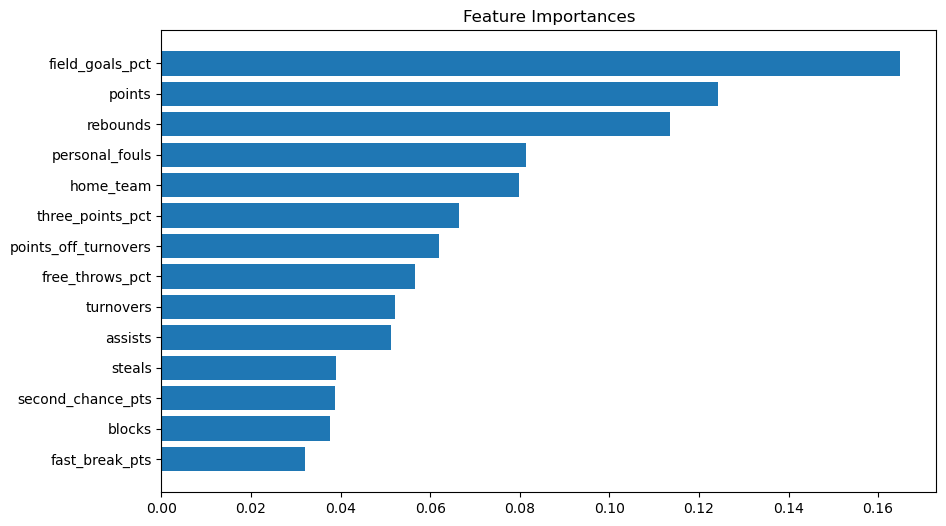

In [44]:
# Get feature importances
importances = model.feature_importances_
sorted_idx = importances.argsort()

# Plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [features[i] for i in sorted_idx])
plt.title("Feature Importances")
plt.show()

In [52]:
def get_all_teams():
    """Fetch team IDs and names using verified columns"""
    query = """
    SELECT 
        DISTINCT team_id, 
        market AS team_name  # Changed from team_market to market
    FROM `bigquery-public-data.ncaa_basketball.mbb_teams_games_sr`
    WHERE market IS NOT NULL
    ORDER BY team_name
    """
    return client.query(query).to_dataframe()

# Create team name mapping
teams_df = get_all_teams()
print(teams_df)
team_name_to_id = dict(zip(teams_df['team_name'], teams_df['team_id']))


/opt/homebrew/anaconda3/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


                                  team_id                     team_name
0    a52b2ece-1f87-45b5-ae1e-8d0920479965             Abilene Christian
1    b4b87d2c-9af2-455b-adc1-4e484c078912                   Adams State
2    992f4869-3d63-4ddf-888a-e7bd25f61b2a                        Adrian
3    aa7af640-5762-4686-9181-39f7b8a8186e                     Air Force
4    56fe0ab2-e4f0-47b9-8726-9ce23ebcde20                         Akron
..                                    ...                           ...
994  ca478771-aa3d-4231-81e0-b70f519134fb                          Yale
995  34309039-b4f3-4afc-96a3-844ec0e9a150             York College (NE)
996  6560815b-8df7-4198-af3b-46c2e8e92560  York College of Pennsylvania
997  95e578e8-08ca-4b78-8125-498cbdf76360                  Young Harris
998  da7d41bc-48b0-4a04-948f-792d6470bcb5              Youngstown State

[999 rows x 2 columns]


In [58]:
def predict_matchup_by_names(team1_name, team2_name, season):
    # Get team IDs
    team1_id = team_name_to_id.get(team1_name)
    team2_id = team_name_to_id.get(team2_name)
    
    if not team1_id or not team2_id:
        raise ValueError("Team names not found")

    # Historical matchup query (verified)
    history_query = f"""
    WITH matchups AS (
      SELECT
        g.game_id,
        g.scheduled_date,
        t1.market AS team1,
        t2.market AS team2,
        CASE WHEN t1.win THEN t1.market ELSE t2.market END AS winner
      FROM `bigquery-public-data.ncaa_basketball.mbb_games_sr` g
      JOIN `bigquery-public-data.ncaa_basketball.mbb_teams_games_sr` t1
        ON g.game_id = t1.game_id
      JOIN `bigquery-public-data.ncaa_basketball.mbb_teams_games_sr` t2
        ON g.game_id = t2.game_id AND t1.team_id < t2.team_id
      WHERE ((t1.team_id = '{team1_id}' AND t2.team_id = '{team2_id}')
          OR (t1.team_id = '{team2_id}' AND t2.team_id = '{team1_id}'))
        AND g.season = {season}
    )
    SELECT * FROM matchups
    """

    # Corrected stats query with proper type handling
    def get_team_stats(team_id, season):
        query = f"""
        SELECT 
            AVG(CASE WHEN home_team THEN 1.0 ELSE 0.0 END) as home_team,  # Convert boolean to float
            AVG(points) as points,
            AVG(field_goals_pct) as field_goals_pct,
            AVG(three_points_pct) as three_points_pct,
            AVG(free_throws_pct) as free_throws_pct,
            AVG(rebounds) as rebounds,
            AVG(assists) as assists,
            AVG(turnovers) as turnovers,
            AVG(steals) as steals,
            AVG(blocks) as blocks,
            AVG(personal_fouls) as personal_fouls,
            AVG(fast_break_pts) as fast_break_pts,
            AVG(second_chance_pts) as second_chance_pts,
            AVG(points_off_turnovers) as points_off_turnovers
        FROM `bigquery-public-data.ncaa_basketball.mbb_teams_games_sr`
        WHERE team_id = '{team_id}' AND season = {season}
        """
        return client.query(query).to_dataframe().iloc[0].to_dict()
    
    team1_stats = get_team_stats(team1_id, season)
    team2_stats = get_team_stats(team2_id, season)
    
    # Force home/away flags (already converted to float)
    team1_stats['home_team'] = 1.0  # Must match training data format
    team2_stats['home_team'] = 0.0
    
    # Predict
    team1_prob = model.predict_proba(pd.DataFrame([team1_stats]))[0][1]
    team2_prob = model.predict_proba(pd.DataFrame([team2_stats]))[0][1]
    
    return {
        'team1': team1_name,
        'team2': team2_name,
        'team1_win_prob': round(team1_prob, 3),
        'team2_win_prob': round(team2_prob, 3),
        'historical_matchups': client.query(history_query).to_dataframe().to_dict('records')
    }


In [60]:
# Predict Duke vs North Carolina in 2017
result = predict_matchup_by_names("Duke", "North Carolina", 2017)
print(result)


print(f"Prediction: {result['team1']} {result['team1_win_prob']*100:.1f}% vs {result['team2']} {result['team2_win_prob']*100:.1f}%")

print("\nPast few matchups:")
print(pd.DataFrame(result['historical_matchups']).head())


/opt/homebrew/anaconda3/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


{'team1': 'Duke', 'team2': 'North Carolina', 'team1_win_prob': 0.99, 'team2_win_prob': 0.93, 'historical_matchups': [{'game_id': '7c3b1af4-2840-454f-b907-5c4df4e69808', 'scheduled_date': datetime.date(2018, 2, 9), 'team1': 'North Carolina', 'team2': 'Duke', 'winner': 'North Carolina'}, {'game_id': 'e137cf63-fd32-4c07-874d-2a06d71071eb', 'scheduled_date': datetime.date(2018, 3, 4), 'team1': 'North Carolina', 'team2': 'Duke', 'winner': 'Duke'}, {'game_id': '03df73fa-9c09-43ea-a874-3c6746558981', 'scheduled_date': datetime.date(2018, 3, 10), 'team1': 'North Carolina', 'team2': 'Duke', 'winner': 'North Carolina'}]}
Prediction: Duke 99.0% vs North Carolina 93.0%

Past few matchups:
                                game_id scheduled_date           team1 team2  \
0  7c3b1af4-2840-454f-b907-5c4df4e69808     2018-02-09  North Carolina  Duke   
1  e137cf63-fd32-4c07-874d-2a06d71071eb     2018-03-04  North Carolina  Duke   
2  03df73fa-9c09-43ea-a874-3c6746558981     2018-03-10  North Carolina  Du

/opt/homebrew/anaconda3/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [62]:
#export model
import joblib

# Save the trained model
joblib.dump(model, 'ncaa_model.pkl')

# Optional: Save team name mappings
import json
with open('team_mappings.json', 'w') as f:
    json.dump({
        'name_to_id': team_name_to_id,
        'id_to_name': {v:k for k,v in team_name_to_id.items()}
    }, f)
